### FSEOF Analysis

FSEOF analysis, an acronym for Flux Scanning based on Enforced Objective Flux, reveals reactions that can be altered in flux to enhance the production of a specific compound - in this project, Artemisinin. This enhancement is achieved by progressively enforcing a flux increase in the objective, with the specific objective in this project being the reaction (ALDH1_CYP71AV1) that produces dihydroartemsinic acid, the precursor to artemisinin.

In [85]:
# Loading of required packages
from cobra.io import read_sbml_model, write_sbml_model # To read the model and save new newly generated model
# from cobra import Reaction, Metabolite # To create new reactions and metabolites NOT NECESSARY WILL DELETE THIS
from cameo.strain_design.deterministic.flux_variability_based import FSEOF # To make FSEOF analysis
import numpy as np # Arrays
from matplotlib import pyplot as plt # Plotting
from pytest import approx # using the approximation function

In [86]:
# Loading of the model
iYO844 = read_sbml_model("data/iYO844_modified.xml")
# Observe access to modified model 
iYO844

Name,iYO844
Memory address,0x019adeb2c5c8
Number of metabolites,996
Number of reactions,1258
Number of groups,0
Objective expression,1.0*BIOMASS_BS_10 - 1.0*BIOMASS_BS_10_reverse_8788b
Compartments,"cytosol, extracellular space"


In [87]:
# Perform flux variability analysis on the modified model to explore and optimize the flux space of the model
fseof = FSEOF(iYO844)

In [88]:
# We want to target the flux of reaction 6 called ALDH1_CYP71AV1 within the cell
fseof_result = fseof.run(target=iYO844.reactions.ALDH1_CYP71AV1)
fseof_result_df = fseof_result.data_frame # Creating a data frame object with fseof_result
# The data frame represents a table where each row corresponds to a specific metabolic reaction,   
# and each column represents the reaction flux under different conditions. "Conditions" typically refers to different
# levels or values of the enforced objective flux (ALDH1_CYP71AV1). The enforced objective flux is systematically 
# varied to explore how changes in this flux influence the flux distribution of other reactions in the 
# metabolic network. The enforced objective flux is in this analysis most likely
# systematically varied in increasing increments. 

Following the analysis, a plot can be generated illustrating the predicted enzyme/reaction targets that exhibit either an increase or decrease in flux when the specific objective is set to the penultimate reaction of the artemisinin pathway: ALDH1_CYP71AV1 that produces dihydroartemsinic acid.

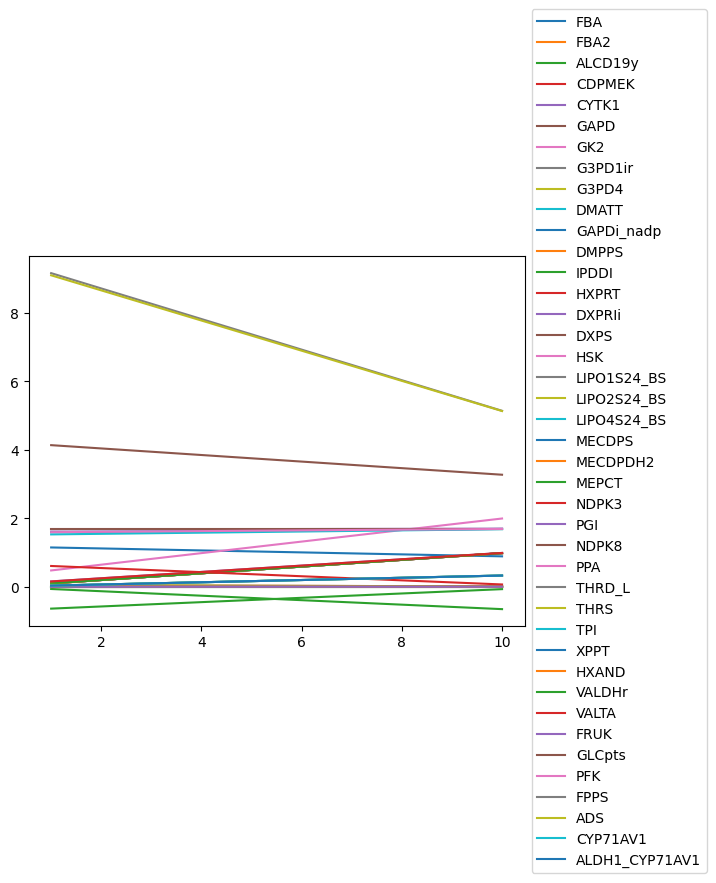

In [89]:
# The results from FSEOF analysis are plotted
fseof_result_df.T.plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("figures/FSEOF.png")
plt.show()

For a clearer overview of the results, we arrange the fluxes in descending order and eliminate those with a flux of 0.0.

In [90]:
# Sorting the dataframe from highest to lowest (descending order)
fseof_result_df = fseof_result_df.sort_values([1], ascending = False)
 
# Finding all the values, which are not approximatly equal to 0 - hence almost no flux.
removed_zero = (fseof_result_df != approx(0.0)).all(axis=1)
fseof_result_df = fseof_result_df.loc[removed_zero] # Removing genes from data frame, which have no flux change
fseof_result_df.head() # Shows the header of the data frame

,1,2,3,4,5,6,7,8,9,10
G3PD1ir,9.161652,8.714794,8.267937,7.821079,7.374221,6.927363,6.480505,6.033647,5.586789,5.139931
G3PD4,9.098386,8.657785,8.217184,7.776584,7.335983,6.895382,6.454781,6.014181,5.573580,5.132979
GAPD,4.136318,4.040324,3.944330,3.848336,3.752343,3.656349,3.560355,3.464361,3.368367,3.272373
GLCpts,1.700000,1.700000,1.700000,1.700000,1.700000,1.700000,1.700000,1.700000,1.700000,1.700000
PGI,1.672989,1.675661,1.678332,1.681003,1.683675,1.686346,1.689018,1.691689,1.694360,1.697032


In [91]:
len(fseof_result_df) # Number of rows (reactions) in data frame

41

The table above shows the top 5 reactions with highest increase or decrease in flux, where each column represents the reaction flux under increasing values of the enforced objective flux (ALDH1_CYP71AV1). The whole data frame contains 41 rows, corresponding to 41 reactions having a change of flux.

Visualization of the results:

Text(0.5, 1.0, 'Flux scanning based on Enforced Objective Flux')

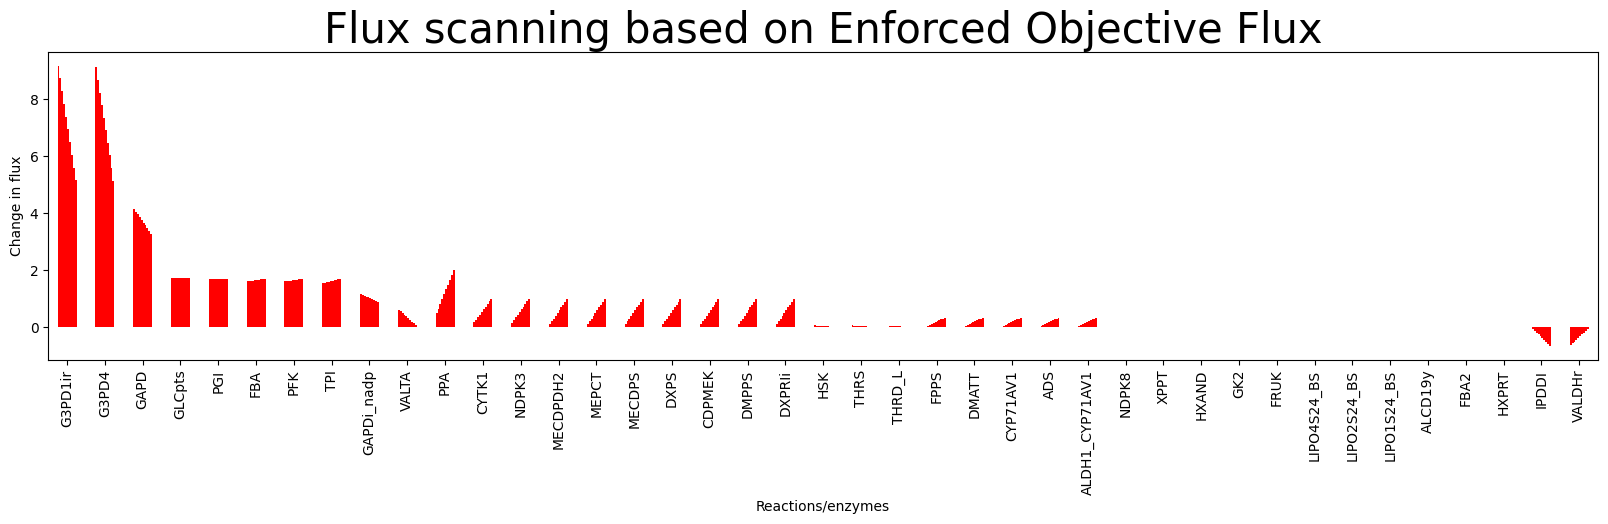

In [92]:
# Creating a function, which has three input variables
# returns colouring of the values in the data frame
def bar_color(fseof_result_df, color1, color2):
    return np.where(fseof_result_df.values >= 0, color1, color2).flatten()

# Generating a plot
fig = fseof_result_df.plot(
    legend=None,
    kind='bar',
    color=bar_color(fseof_result_df, 'red', 'blue'),
    figsize=(20, 4),
    grid=False
)

fig.set_ylabel('Change in flux')
fig.set_xlabel('Reactions/enzymes')
fig.set_title('Flux scanning based on Enforced Objective Flux', size=30)

From the plot, it can be observed that most of the fluxes are increased in the analysis. 

Now, our objective is to see which reactions are conferred the highest relative change in flux when the flux through ALDH1_CYP71AV1 is increased. 
This calculation can be performed as follows: R = (B-A)/B + 1, where A and B represent different states of fluxes from the same reaction. The addition of 1 ensures that the result is presented as a relative change, with a value of 1 indicating no change.

In [93]:
# The realtive change in flux is calculated with the above formula
fseof_result_df['relative_change_in_flux'] = (fseof_result_df[10]-fseof_result_df[1])/fseof_result_df[10] +1

We can identify target reactions by examining the reactions with a relative change in flux exceeding 80%:

In [94]:
# Filtering the 'relative_change_in_flux' column in fseof_result_df for values greater than 1.8 (80%)
target_reactions_df = fseof_result_df[fseof_result_df['relative_change_in_flux'] > 1.8]
target_reactions_df

,1,2,3,4,5,6,7,8,9,10,relative_change_in_flux
CYTK1,0.155970,0.248375,0.340780,0.433185,0.525590,0.617995,0.710400,0.802805,0.895210,0.987615,1.842074
NDPK3,0.154077,0.246669,0.339261,0.431853,0.524446,0.617038,0.709630,0.802222,0.894814,0.987407,1.843958
MECDPDH2,0.098326,0.196432,0.294538,0.392644,0.490750,0.588856,0.686962,0.785068,0.883174,0.981280,1.899798
MEPCT,0.098326,0.196432,0.294538,0.392644,0.490750,0.588856,0.686962,0.785068,0.883174,0.981280,1.899798
MECDPS,0.098326,0.196432,0.294538,0.392644,0.490750,0.588856,0.686962,0.785068,0.883174,0.981280,1.899798
DXPS,0.098326,0.196432,0.294538,0.392644,0.490750,0.588856,0.686962,0.785068,0.883174,0.981280,1.899798
CDPMEK,0.098326,0.196432,0.294538,0.392644,0.490750,0.588856,0.686962,0.785068,0.883174,0.981280,1.899798
DMPPS,0.098326,0.196432,0.294538,0.392644,0.490750,0.588856,0.686962,0.785068,0.883174,0.981280,1.899798
DXPRIi,0.098326,0.196432,0.294538,0.392644,0.490750,0.588856,0.686962,0.785068,0.883174,0.981280,1.899798
FPPS,0.032737,0.065443,0.098149,0.130855,0.163560,0.196266,0.228972,0.261678,0.294383,0.327089,1.899914


In [95]:
# Number of reactions with relative change in flux exceeding 80%
len(target_reactions_df)

15

In [96]:
# Removing column labeled 'relative_change_in_flux' from target_reactions_df
# CHANGE NAME OF DF: IT SAYS NOTHING OF THE VARIABLE
df = target_reactions_df.drop(labels='relative_change_in_flux', axis=1)

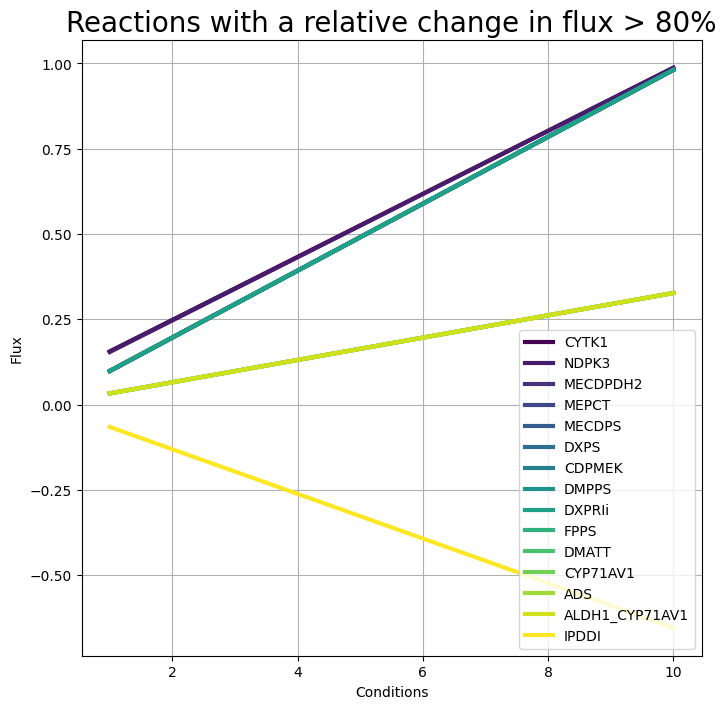

In [97]:
# Plotting the reactions with relative change in flux exceeding 80%
fig = df.T.plot(cmap="viridis",figsize=(8, 8), grid =True, linewidth=3);
fig.set_ylabel('Flux')
fig.set_xlabel('Conditions')
fig.set_title('Reactions with a relative change in flux > 80%', size=20)
fig.get_figure().savefig("figures/Rec_Change_Flux_Above_80.png")

In the figure, we only observe what looks like 4 different curves. This is because the fluxes of:
- FPPS, DMATT, CYP71AV1, ADS and ALDH1_CYP71AV1 exactly overlap
- CYTK1 and NDPK3 exactly overlap
- MECDPDH2, MEPCT, MECDPS, DXPS, CDPMEK, DMPPS and DXPRIi exactly overlap

This must mean that these reactions most likely are coupled in the model.

In [105]:
# Sorting the DataFrame in descending order of highest relative change in flux
target_reactions_df = target_reactions_df.sort_values(by='relative_change_in_flux', ascending=False)
target_reactions_df

,1,2,3,4,5,6,7,8,9,10,relative_change_in_flux
ALDH1_CYP71AV1,0.032709,0.065417,0.098126,0.130834,0.163543,0.196252,0.228960,0.261669,0.294377,0.327086,1.900000
CYP71AV1,0.032709,0.065417,0.098126,0.130834,0.163543,0.196252,0.228960,0.261669,0.294377,0.327086,1.899999
ADS,0.032709,0.065417,0.098126,0.130834,0.163543,0.196252,0.228960,0.261669,0.294377,0.327086,1.899999
FPPS,0.032737,0.065443,0.098149,0.130855,0.163560,0.196266,0.228972,0.261678,0.294383,0.327089,1.899914
DMATT,0.032737,0.065443,0.098149,0.130855,0.163560,0.196266,0.228972,0.261678,0.294383,0.327089,1.899914
MECDPDH2,0.098326,0.196432,0.294538,0.392644,0.490750,0.588856,0.686962,0.785068,0.883174,0.981280,1.899798
MEPCT,0.098326,0.196432,0.294538,0.392644,0.490750,0.588856,0.686962,0.785068,0.883174,0.981280,1.899798
MECDPS,0.098326,0.196432,0.294538,0.392644,0.490750,0.588856,0.686962,0.785068,0.883174,0.981280,1.899798
DXPS,0.098326,0.196432,0.294538,0.392644,0.490750,0.588856,0.686962,0.785068,0.883174,0.981280,1.899798
CDPMEK,0.098326,0.196432,0.294538,0.392644,0.490750,0.588856,0.686962,0.785068,0.883174,0.981280,1.899798


The reactions that have the highest relative change in flux are the ones that are most sensitive to changes in flux through the ALDH1_CYP71AV1 reaction. These are the ones we're interested in as they also are the ones that produce the highest flux through ALDH1_CYP71AV1 (kan dette bekræftes?)

Since many of the reactions in the model are coupled, more than 10 targets for up- or downregulation will be mentioned.
#### Top 12 targets for up- or downregulation:
- **CYP71AV1** amorphadiene oxidase (we inserted this reaction)
- **ADS** amorphadiene synthase (we inserted this reaction)
- **FPPS** farnesyl pyrophosphate synthase (we inserted this reaction)
- **DMATT** Dimethylallyltranstransferase
- **MECDPDH2** 2C-methyl-D-erythritol 2,4 cyclodiphosphate dehydratase
- **MEPCT** 2-C-methyl-D-erythritol 4-phosphate cytidylyltransferase
- **MECDPS** 2-C-methyl-D-erythritol 2,4-cyclodiphosphate synthase
- **DXPS** 1-deoxy-D-xylulose 5-phosphate synthase
- **CDPMEK** 4-(cytidine 5'-diphospho)-2-C-methyl-D-erythritol kinase
- **DMPPS** 1-hydroxy-2-methyl-2-(E)-butenyl 4-diphosphate reductase (dmpp)
- **DXPRIi** 1-deoxy-D-xylulose reductoisomerase
- **IPDDI** Isopentenyl-diphosphate D-isomerase
Downregulating the flux through IPDDI upregulates the flux through ALDH1_CYP71AV1 (IPDDI both has flux to and from pathway)

Many of the enzymes are found in the MEP pathway (MEPCT, MECDPDH2, MECDPS, DXPS, etc.)

#### Summary
(Make summary of analysis)